# **Install Kaggle**

In [80]:
!pip install -q kaggle

# **Upload Kaggle**

In [81]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"candrajuliussinaga","key":"f1b5e10673fde9255b882ba2af119a93"}'}

# **Make Directory and Change Permission Package**


In [82]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


# **Download Dataset from Kaggle**

In [83]:
!kaggle datasets download -d meetnagadia/walmart-stock-price-from-19722022

walmart-stock-price-from-19722022.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Extract File Zip from Dataset**

In [84]:
from zipfile import ZipFile
file_name = '/content/walmart-stock-price-from-19722022.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Extract zip file done')

Extract zip file done


# **Prepare Dataset & Load Dataset**

In [85]:
import numpy as np
import pandas as pd
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [86]:
data_train = pd.read_csv('/content/WMT.csv')
data_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.063477,0.064697,0.063477,0.064453,0.036447,2508800
1,1972-08-28,0.064453,0.064941,0.064209,0.064209,0.036309,972800
2,1972-08-29,0.063965,0.063965,0.063477,0.063477,0.035895,1945600
3,1972-08-30,0.063477,0.063477,0.062988,0.063477,0.035895,409600
4,1972-08-31,0.062988,0.062988,0.062500,0.062500,0.035343,870400


# **Find Missing Values from Dataset**

In [87]:
data_train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# **Finding Missing Values Again**

In [88]:
data_train.isnull()

,Date,Open,High,Low,Close,Adj Close,Volume
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
12486,False,False,False,False,False,False,False
12487,False,False,False,False,False,False,False
12488,False,False,False,False,False,False,False
12489,False,False,False,False,False,False,False


# **Convert Data to Numpy Array From Values And Make Histogram**

Text(0.5, 1.0, 'Walmart Stock Price For High')

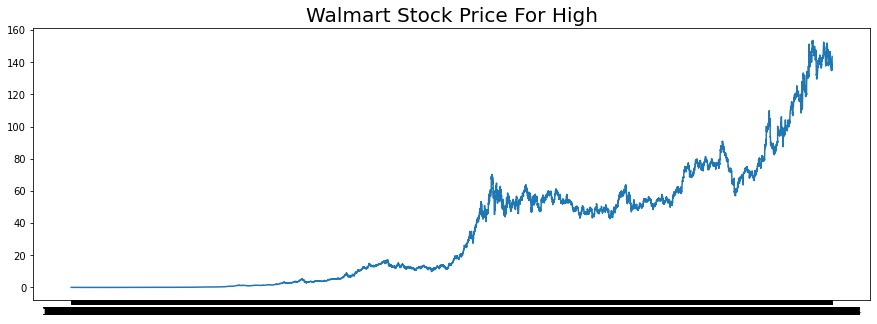

In [89]:
dates = data_train['Date'].values
stock = data_train['High'].values

plt.figure(figsize=(15,5))
plt.plot(dates,stock)
plt.title("Walmart Stock Price For High", fontsize=20)

# **Convert Data With Function**

In [90]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

# **Training Data and Validation Data**

In [91]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(stock,dates,test_size=0.2,random_state=0, shuffle=False)


# **Arsitekture for LSTM**

In [92]:
train_set = windowed_dataset(x_train,window_size=60,batch_size=100,shuffle_buffer=1000)
test_set = windowed_dataset(x_test,window_size=60,batch_size=100,shuffle_buffer=6000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# **Make Optimizer**

In [93]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

In [94]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [95]:
thresold = (data_train['High'].max() - data_train['High'].min()) * 10/100
print(thresold)

15.364437899999999


In [96]:
class CallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if  (logs.get('mae') < thresold):
      print('\n Mae model anda telah mencapai < 10%')
      self.model.stop_training = True
myCallback = CallBack()

# **Fit Data**

In [97]:
history = model.fit(train_set,epochs=100,validation_data=test_set,callbacks=[myCallback])

Epoch 1/100
100/100 [==============================] - 22s 161ms/step - loss: 15.3779 - mae: 15.8724 - val_loss: 45.8335 - val_mae: 46.3335
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 13.5242 - mae: 14.0131
 Mae model anda telah mencapai < 10%
100/100 [==============================] - 15s 147ms/step - loss: 13.5242 - mae: 14.0131 - val_loss: 43.8608 - val_mae: 44.3608


# **Make a Plot Loss and Plot Mae**

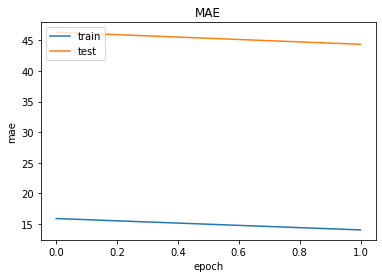

In [98]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

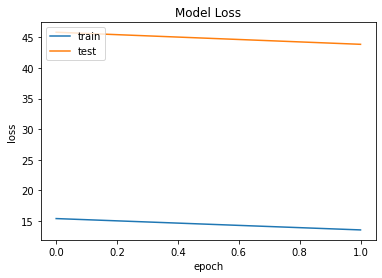

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()